# Bearing Failure Anomaly Detection

### Blog: https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
### Github: https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection

In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [9]:
!pip install scikit-learn joblib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

2024-12-10 17:07:52.595131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733846872.623389  133555 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733846872.631785  133555 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 17:07:52.659606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [4]:
# load, average and merge sensor samples
data_dir = "./Sensor_Data/Bearing"
merged_data =[]

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data.append(dataset_mean_abs)
merged_data = pd.concat(merged_data)



    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [5]:
print(merged_data)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004.02.16.09.02.39   0.068176   0.073138   0.076444   0.044163
2004.02.16.09.12.39   0.068067   0.072616   0.076371   0.044726
2004.02.16.09.22.39   0.069418   0.074628   0.076325   0.044795
2004.02.16.09.32.39   0.069051   0.073779   0.078401   0.043940
2004.02.16.09.42.39   0.070402   0.074372   0.077285   0.044330
...                        ...        ...        ...        ...
2004.02.16.08.12.39   0.068666   0.073713   0.076643   0.044780
2004.02.16.08.22.39   0.069816   0.074752   0.075782   0.044493
2004.02.16.08.32.39   0.067804   0.073470   0.077167   0.044140
2004.02.16.08.42.39   0.069240   0.074081   0.076584   0.044239
2004.02.16.08.52.39   0.068675   0.074551   0.077707   0.045168

[982 rows x 4 columns]


In [8]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [9]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


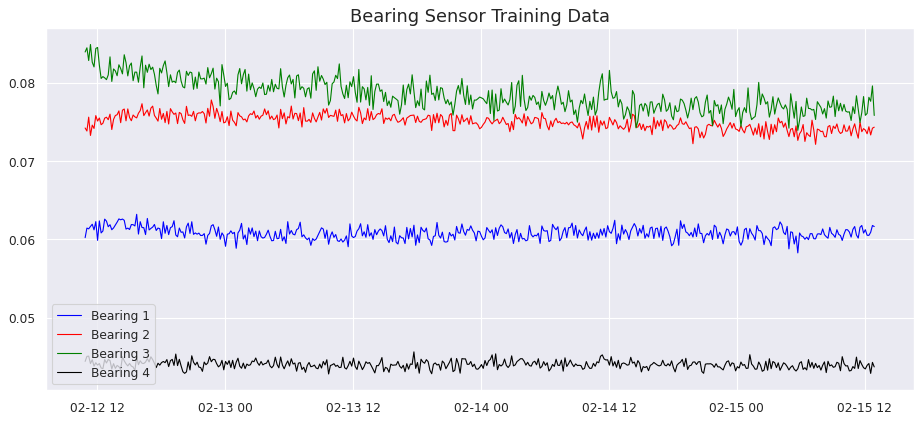

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [10]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

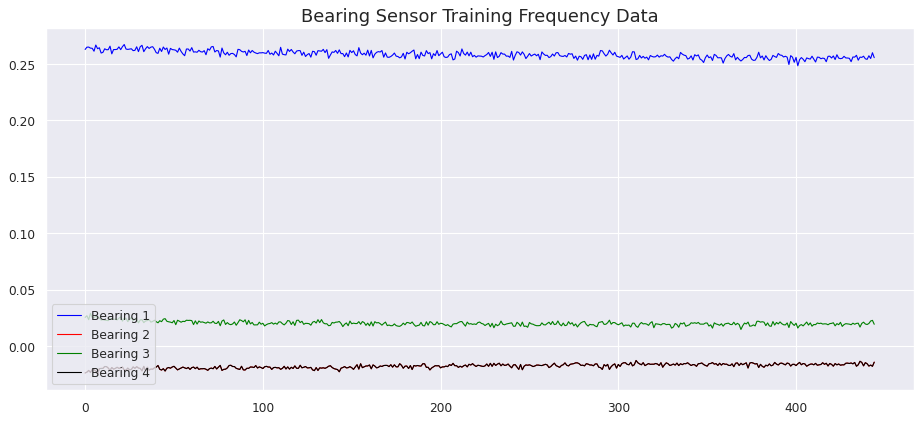

In [9]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].real, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

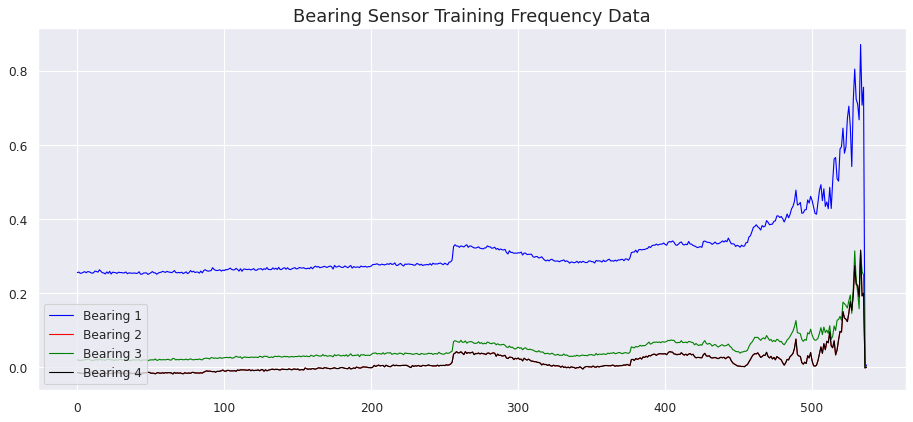

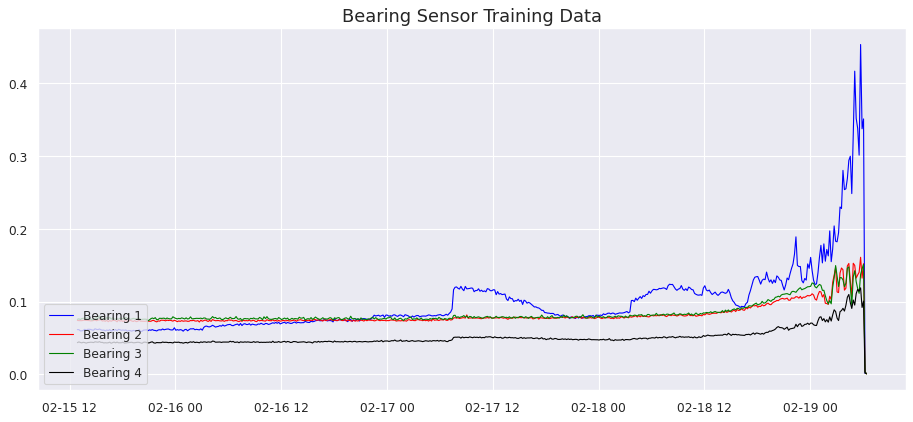

In [10]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].real, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [11]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_test2 = scaler.fit_transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

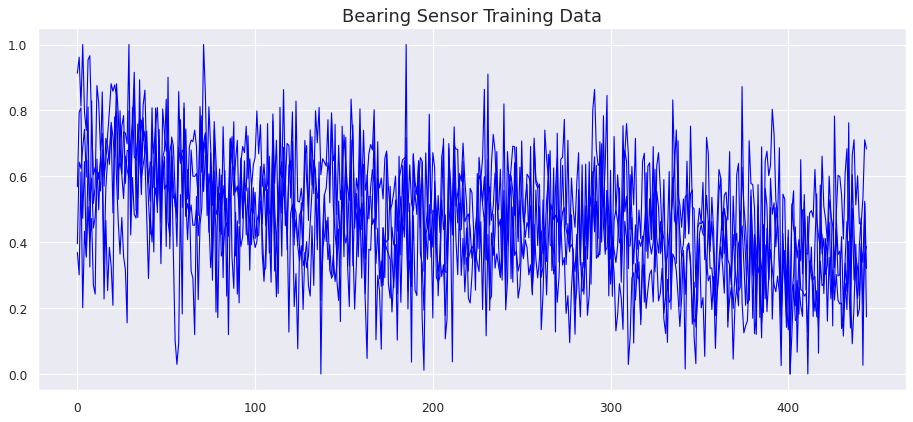

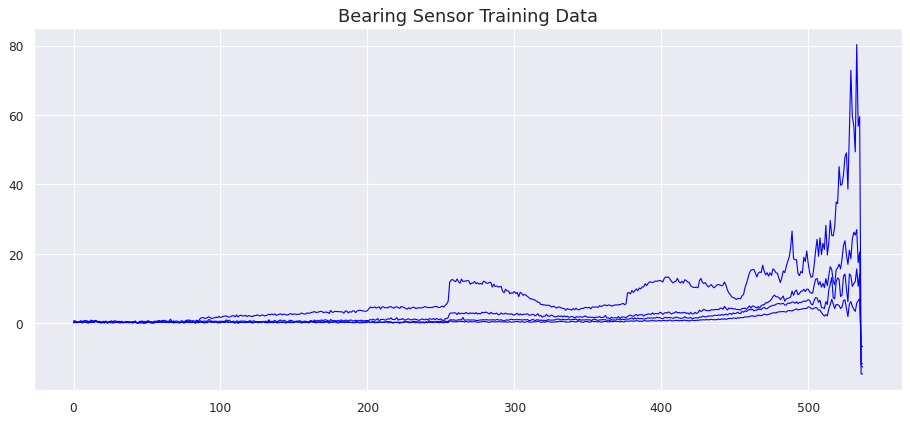

In [12]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_train, label='Bearing 1', color='blue', animated = True, linewidth=1)

ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_test, label='Bearing 1', color='blue', animated = True, linewidth=1)

ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [12]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_test2 = X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [33]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model
autoencoder_model(X_train).save("./model.keras")


ValueError: Input 0 of layer "lstm_23" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 4)

In [36]:
# define the autoencoder network model
def autoencoder_model3(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = Reshape((1, 4))(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model
autoencoder_model3(X_train).save("./model.keras")


In [32]:
X_train.shape

(445, 1, 4)

In [27]:
def repeat_vector(x, repeat_length):
    return tf.tile(tf.expand_dims(x, 1), [1, repeat_length, 1])

# Define the model
def autoencoder_model2(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    encoded = LSTM(16, activation='relu', return_sequences=True)(inputs)
    latent = LSTM(4, activation='relu', return_sequences=False)(encoded)
    decoded = LSTM(4, activation='relu', return_sequences=True)(tf.expand_dims(latent, axis=1))
    outputs = Dense(X.shape[2])(decoded)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [28]:
# create the autoencoder model
model = autoencoder_model2(X_train)

model.compile(optimizer='adam', loss='mae')
model.summary()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [18]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.4605 - val_loss: 0.3245
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4061 - val_loss: 0.2597
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3311 - val_loss: 0.1788
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993 - val_loss: 0.1429
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1077 - val_loss: 0.1123
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1021 - val_loss: 0.1121
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1015 - val_loss: 0.1122
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1008 - val_loss: 0.1118
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - val_loss: 0.1113
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1002 - val_loss: 0.1102
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0999 - val_loss: 0.1096
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [19]:
def representative_data_gen():
    for i in range(100):  # Adjust the range as needed
        input_data = X_train[i:i+1]  # Ensure this slices correctly
        #print(f"Yielding data shape: {input_data.shape}, dtype: {input_data.dtype}")
        yield [input_data.astype(np.float32)]


In [19]:
X_train

array([[[0.39518051, 0.36851684, 0.91295856, 0.56833449]],

       [[0.64304579, 0.30094449, 0.96148238, 0.79465028]],

       [[0.62379364, 0.61266227, 0.81348964, 0.80775623]],

       ...,

       [[0.53419516, 0.21178246, 0.33869465, 0.02647161]],

       [[0.71083045, 0.36463536, 0.51749078, 0.52396122]],

       [[0.68310894, 0.38704446, 0.17330254, 0.32004848]]])

In [25]:
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
# create the autoencoder model
#model = autoencoder_model2(X_train)
#model.compile(optimizer='adam', loss='mae')
#model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Set input type to int8
converter.inference_output_type = tf.int8  #
converter.experimental_new_converter = True
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite built-in operations
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow operations that are not natively supported
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()
with open('./autoencoder_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpd8zs8ue1/assets


INFO:tensorflow:Assets written to: /tmp/tmpd8zs8ue1/assets


Saved artifact at '/tmp/tmpd8zs8ue1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None)
Captures:
  140003623771152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623771536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623770576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623772112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623773648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623776336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623775568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623776912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140003623778448:

/home/pietro/.local/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733234076.027220  235600 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733234076.027239  235600 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-03 14:54:36.027541: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd8zs8ue1
2024-12-03 14:54:36.031194: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-03 14:54:36.031245: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpd8zs8ue1
2024-12-03 14:54:36.063010: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-03 14:54:36.173925: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpd8zs

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test2.reshape(X_test2.shape[0], X_test2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored=pd.concat([scored_train, scored])

In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [ ]:
# save all model information, including weights, in h5 format
model.save("bearing-sensor-anomaly-detection.h5")
print("Model saved")